## Hidden Markov Model

Assumption: High volatility (measured by daily price range = High - Low) reflects uncertainty or risk and could signal a market regime shift.

In [2]:
!pip install cybotrade_datasource
!pip install python-dotenv
!pip install hmmlearn

import pandas as pd
import numpy as np
import asyncio
import cybotrade_datasource
from datetime import datetime, timezone
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


import warnings as wr
wr.filterwarnings('ignore')

print(dir(cybotrade_datasource))

load_dotenv()

API_KEY = os.getenv('CYBOTRADE_API_KEY')


global_df = None 

async def get_data(topic):
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic=topic, 
        limit=10000
    )
    return pd.DataFrame(data)


async def main():
    global global_df

    topics = [
        "bybit-linear|candle?symbol=BTCUSDT&interval=1m",
    ]

#topic
#"cryptoquant|btc/market-data/open-interest?exchange=bybit&window=min",
#bybit-linear|candle?interval=1m&symbol=BTCUSDT
#"cryptoquant|btc/market-data/coinbase-premium-index?window=hour",
#"cryptoquant|btc/exchange-flows/outflow?exchange=coinbase_advanced&window=hour",
#"glassnode|market/deltacap_usd?a=BTC&i=10m",

    tasks = [get_data(topic) for topic in topics]
    dataframes = await asyncio.gather(*tasks)

    for i, df in enumerate(dataframes):
        print(f"DataFrame {i+1} ({topics[i]})")
        print(df.head)
        print(df.isnull().sum())
        global_df = df

await main()



DataFrame 1 (bybit-linear|candle?symbol=BTCUSDT&interval=1m)
<bound method NDFrame.head of          start_time    close     high      low     open   volume
0     1743750840000  83501.3  83560.5  83479.9  83479.9  309.717
1     1743750900000  83461.8  83549.8  83443.2  83501.3  111.442
2     1743750960000  83456.6  83461.8  83412.1  83461.8   94.248
3     1743751020000  83543.9  83559.2  83408.1  83456.6   95.114
4     1743751080000  83452.7  83544.0  83441.4  83543.9  181.538
...             ...      ...      ...      ...      ...      ...
9995  1744350540000  80641.1  80641.1  80616.7  80627.2   26.437
9996  1744350600000  80655.9  80686.5  80641.1  80641.1   13.068
9997  1744350660000  80676.7  80688.9  80640.8  80655.9   16.344
9998  1744350720000  80655.9  80682.6  80650.5  80676.7    9.435
9999  1744350780000  80686.0  80686.0  80640.9  80655.9   53.368

[10000 rows x 6 columns]>
start_time    0
close         0
high          0
low           0
open          0
volume        0
dtype

In [3]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')


print(global_df[['start_time']])

              start_time
0    2025-04-04 07:14:00
1    2025-04-04 07:15:00
2    2025-04-04 07:16:00
3    2025-04-04 07:17:00
4    2025-04-04 07:18:00
...                  ...
9995 2025-04-11 05:49:00
9996 2025-04-11 05:50:00
9997 2025-04-11 05:51:00
9998 2025-04-11 05:52:00
9999 2025-04-11 05:53:00

[10000 rows x 1 columns]


In [4]:
global_df.head()

,start_time,close,high,low,open,volume
0,2025-04-04 07:14:00,83501.3,83560.5,83479.9,83479.9,309.717
1,2025-04-04 07:15:00,83461.8,83549.8,83443.2,83501.3,111.442
2,2025-04-04 07:16:00,83456.6,83461.8,83412.1,83461.8,94.248
3,2025-04-04 07:17:00,83543.9,83559.2,83408.1,83456.6,95.114
4,2025-04-04 07:18:00,83452.7,83544.0,83441.4,83543.9,181.538


Define feature:

In [8]:
global_df['Volatility'] = global_df['high'] - global_df['low']
X = global_df[['Volatility']].values  
print(global_df['Volatility'])

0        80.6
1       106.6
2        49.7
3       151.1
4       102.6
        ...  
9995     24.4
9996     45.4
9997     48.1
9998     32.1
9999     45.1
Name: Volatility, Length: 10000, dtype: float64


Train /test split

In [15]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]

Define and Train HMM

In [16]:
model = GaussianHMM(n_components=3, covariance_type='full', n_iter=100, random_state=42)
model.fit(X_train)

GaussianHMM(covariance_type='full', n_components=3, n_iter=100, random_state=42)

Predict

In [17]:
# Predict on training and test set
train_states = model.predict(X_train)
test_states = model.predict(X_test)

global_df['State'] = np.concatenate([train_states, test_states])

In [18]:
print(global_df)

              start_time    close     high      low     open   volume  \
0    2025-04-04 07:14:00  83501.3  83560.5  83479.9  83479.9  309.717   
1    2025-04-04 07:15:00  83461.8  83549.8  83443.2  83501.3  111.442   
2    2025-04-04 07:16:00  83456.6  83461.8  83412.1  83461.8   94.248   
3    2025-04-04 07:17:00  83543.9  83559.2  83408.1  83456.6   95.114   
4    2025-04-04 07:18:00  83452.7  83544.0  83441.4  83543.9  181.538   
...                  ...      ...      ...      ...      ...      ...   
9995 2025-04-11 05:49:00  80641.1  80641.1  80616.7  80627.2   26.437   
9996 2025-04-11 05:50:00  80655.9  80686.5  80641.1  80641.1   13.068   
9997 2025-04-11 05:51:00  80676.7  80688.9  80640.8  80655.9   16.344   
9998 2025-04-11 05:52:00  80655.9  80682.6  80650.5  80676.7    9.435   
9999 2025-04-11 05:53:00  80686.0  80686.0  80640.9  80655.9   53.368   

      Volatility  State  
0           80.6      1  
1          106.6      0  
2           49.7      0  
3          151.1   

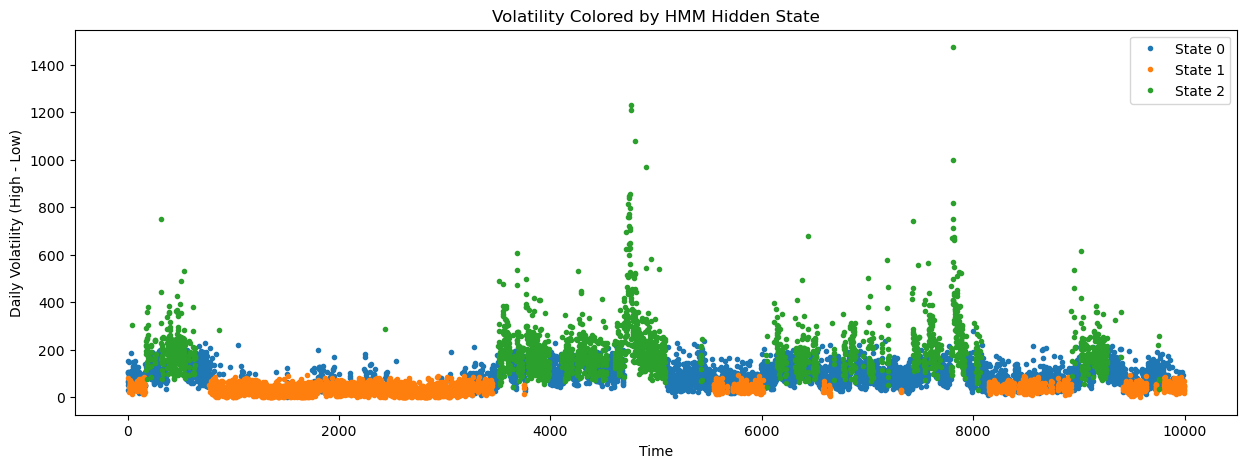

In [19]:
plt.figure(figsize=(15, 5))
for i in range(model.n_components):
    state = global_df['State'] == i
    plt.plot(global_df.index[state], global_df['Volatility'][state], '.', label=f'State {i}')
plt.title("Volatility Colored by HMM Hidden State")
plt.xlabel("Time")
plt.ylabel("Daily Volatility (High - Low)")
plt.legend()
plt.show()

In [21]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'])

# Set it as index
global_df.set_index('start_time', inplace=True)